In [1]:
from typing import Literal
from pydantic import BaseModel

class SupervisorDecision(BaseModel):
    next: Literal['researcher', 'coder', 'FINISH']

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
load_dotenv()

model = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0).with_structured_output(SupervisorDecision)

In [3]:
# 사용 가능한 에이전트 정의
agents = ['researcher', 'coder']


# 시스템 프롬프트 정의
system_prompt_part_1 = f'''당신은 다음 서브에이전트 사이의 대화를 관리하는 슈퍼바이저입니다. 서브에이전트: {agents}. 아래 사용자 요청에 따라,  
다음으로 행동할 서브에이전트를 지목하세요. 각 서브에이전트는 임무를 수행하고 결과와 상태를 응답합니다. 실행할 서브에이전트가 없거나 작업이 완료되면,  
FINISH로 응답하세요.'''

system_prompt_part_2 = f'''위 대화를 바탕으로, 다음으로 행동할 서브에이전트는 누구입니까? 아니면 FINISH 해야 합니까? 서브에이전트: {', '.join(agents)}, FINISH'''

In [4]:
def supervisor(state):
    messages = [
        ('system', system_prompt_part_1),
        *state['messages'],
        ('system', system_prompt_part_2),
    ]
    return model.invoke(messages)

In [5]:
from langgraph.graph import StateGraph, MessagesState, START, END

# 에이전트 상태 정의
class AgentState(MessagesState):
    next: Literal['researcher', 'coder', 'FINISH']

In [6]:
# 에이전트 함수 정의
def researcher(state: AgentState):
    # 실제 구현에서는 이 함수가 리서치 작업을 수행합니다.
    # 여기서는 임의로 관련 데이터를 찾는 척 합니다.
    response = {
        'role': 'assistant',
        'content': '관련 데이터를 찾는 중입니다... 잠시만 기다려주세요.',
    }
    # 임의의 데이터 생성
    fake_data = {
        'data': '전세계 인구 데이터: [미국: 331M, 중국: 1.4B, 인도: 1.3B]'
    }
    response['content'] += f'\n찾은 데이터: {fake_data['data']}'
    return {'messages': [response]}

def coder(state: AgentState):
    # 실제 구현에서는 이 함수가 코드를 작성합니다.
    # 여기서는 임의로 코드를 작성하는 척 합니다.
    response = {
        'role': 'assistant',
        'content': '코드를 작성 중입니다... 잠시만 기다려주세요.',
    }
    # 임의의 코드 생성
    fake_code = '''
def visualize_population(data):
    import matplotlib.pyplot as plt

    countries = list(data.keys())
    population = list(data.values())

    plt.bar(countries, population)
    plt.xlabel('Country')
    plt.ylabel('Population')
    plt.title('World Population by Country')
    plt.show()

data = {'USA': 331, 'China': 1400, 'India': 1300}
visualize_population(data)
'''
    response['content'] += f'\n작성된 코드:\n{fake_code}'
    return {'messages': [response]}

In [7]:
# 그래프 구축
builder = StateGraph(AgentState)
builder.add_node('supervisor', supervisor)
builder.add_node('researcher', researcher)
builder.add_node('coder', coder)

builder.add_edge(START, 'supervisor')
# 슈퍼바이저의 결정에 따라 에이전트 중 하나로 라우팅하거나 종료합니다.
builder.add_conditional_edges('supervisor', lambda state: state['next'], {'researcher':'researcher', 'coder':'coder', 'FINISH': END})
builder.add_edge('researcher', 'supervisor')
builder.add_edge('coder', 'supervisor')

graph = builder.compile()

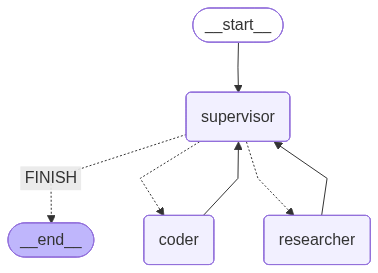

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [9]:
# 예시
initial_state = {
    'messages': [
        {
            'role': 'user',
            'content': '전세계 인구를 국적을 기준으로 시각화 해주세요.',
        }
    ],
    'next': 'supervisor',
}

In [10]:
output = graph.stream(initial_state)

In [11]:
next(output)

{'supervisor': {'next': 'researcher'}}

In [12]:
for output in graph.stream(initial_state):
    node_name, node_result = list(output.items())[0]
    print(f'\n현재 노드: {node_name}')
    if node_result.get('messages'):
        print(f'응답: {node_result['messages'][-1]['content'][:100]}...')
    print(f'\n다음 단계: {node_result.get('next', 'N/A')}') # Not Available


현재 노드: supervisor

다음 단계: researcher

현재 노드: researcher
응답: 관련 데이터를 찾는 중입니다... 잠시만 기다려주세요.
찾은 데이터: 전세계 인구 데이터: [미국: 331M, 중국: 1.4B, 인도: 1.3B]...

다음 단계: N/A

현재 노드: supervisor

다음 단계: coder

현재 노드: coder
응답: 코드를 작성 중입니다... 잠시만 기다려주세요.
작성된 코드:

def visualize_population(data):
    import matplotlib.pyplot as ...

다음 단계: N/A

현재 노드: supervisor

다음 단계: FINISH
